# Lab 3: Image Segmentation

## Python packages
**NumPy**: Used functions related to linear algebra and matrix representation. <br>
**SciPy**: Used for convolution <br>
**Matplotlib**: Used for displaying images and graphs <br>
**Functions**: Used to access files related to the course <br>
**Pillow**: Used to store colour images as three-dimensional arrays in which the last dimension represents the colour space <br>

In [17]:
import sys
import math
import numpy as np
from scipy import sparse, optimize
from scipy.spatial import distance_matrix
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from Functions import *
from gaussfft import gaussfft

C:\Users\karen\AppData\Local\Temp\ipykernel_42696\2189325882.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Working with images in PILLOW
**open()** is used to read images from the disk. <br>
**save()** is used to store images. <br>
**resize()** is used to change the size of the image. <br>

In [18]:
def openImage(path):
    """
    Implement file reading to load an image from disk.:
    - Input: path : image path input
    - Output: img : image as numpy array
    """
    img = Image.open(path)
    img = np.asarray(img).astype(np.float32)
    return img

## K-Means Clustering
Let X be a set of pixels and V be a set of K cluster centers in 3D (R,G,B). <br>
% Randomly initialize the K cluster centers <br>
% Compute all distances between pixels and cluster centers <br>
% Iterate L times <br>
% Assign each pixel to the cluster center for which the distance is minimum <br>
% Recompute each cluster center by taking the mean of all pixels assigned to it <br>
% Recompute all distances between pixels and cluster centers <br>

In [19]:
def initialize_cluster_centers(image, K, seed):
    np.random.seed(seed)
    h, w, d = image.shape
    flattened_data = image.reshape(h * w, d)

    # Initialize the list of chosen indices
    chosen_indices = []

    # Randomly pick the first center
    first_index = np.random.choice(h * w)
    chosen_indices.append(first_index)

    # Iteratively pick the most different pixels
    for _ in range(1, K):
        remaining_indices = [i for i in range(h * w) if i not in chosen_indices]
        distances = np.linalg.norm(flattened_data[remaining_indices] - flattened_data[chosen_indices, None, :], axis=2)
        max_distance_index = remaining_indices[np.argmax(np.min(distances, axis=0))]
        chosen_indices.append(max_distance_index)

    # Extract the initial centers
    initial_centers = flattened_data[chosen_indices]
    return initial_centers

def kmeans_segm(image, K, L, seed):
    """
    Implement k-means clustering:
    - Input: image : image input
             K : number of cluster centres
             L : number of iterations
             seed : to initialize random generator
    - Output: segmentation : segmented image with a colour index per pixel
              centers : final cluster centres in 3D colour space
    """
    # This is used to flatten the image
    h, w, d = image.shape
    Ivec = np.reshape(image, (h * w, d))

    # Apply k-means clustering algorithm
    # Initialize cluster centers randomly
    centers = initialize_cluster_centers(image, K, seed)

    # Initialize nearest_clustery
    nearest_cluster = np.zeros_like(Ivec[:, 0])  

    for _ in range(L):
        # Assign pixels to the nearest cluster center by using the distance to the cluster centers
        distances = distance_matrix(Ivec, centers)
        nearest_cluster = np.argmin(distances, axis=1)

        # Update cluster centers
        for k in range(K):
            if np.any(nearest_cluster == k):
                centers[k] = np.mean(Ivec[nearest_cluster == k], axis=0)
            else:
                # Reinitialize the center if the cluster is empty
                centers[k] = Ivec[np.random.choice(Ivec.shape[0])]
    
    # Reshape the segmentation and centers
    segmentation = np.reshape(nearest_cluster, (h, w))
    return segmentation, centers

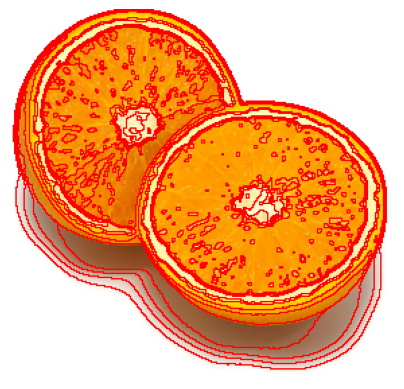

In [20]:
def kmeans_example():
    K = 10              # number of clusters used
    L = 40              # number of iterations
    seed = 14           # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0   # image preblurring scale
    
    img = Image.open('Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
    
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm, centers = kmeans_segm(I, K, L, seed)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/result/orange_kmeans.png')

kmeans_example()


**Question 1** <br>
How did you initialize the clustering process and why do you believe this was a good method of doing it?

**Answer** <br>
The clustering process was initialized by first randomly selecting one pixel from the image, and then iteratively selecting subsequent pixels that were the most different from all previously selected pixels. This method was chosen because it helps in spreading out the initial cluster centers across the color space of the image. By ensuring that the initial centers are as diverse as possible, the entire colour space can be explored leading to a more balanced clustering. This approach tries to prevent the initial centers from being too close to each other, which can be a limitation in random initialization, especially in images with specific color distributions.

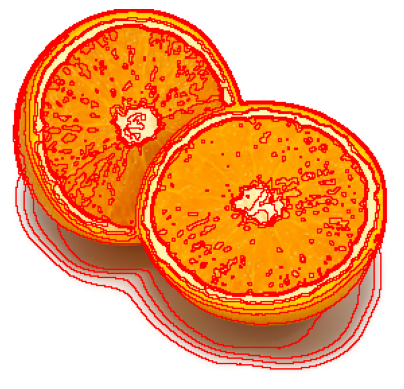

In [21]:
def kmeans_example():
    K = 10             # number of clusters used
    L = 33             # number of iterations
    seed = 14           # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0   # image preblurring scale
    
    img = Image.open('Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
    
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm, centers = kmeans_segm(I, K, L, seed)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/result/orange_L33_kmeans.png')

kmeans_example()

**Question 2**<br>
How many iterations L do you typically need to reach convergence, that is the point where no additional iterations will affect the end results?

**Answer**<br>
I needed around 33 iterations for convergence.

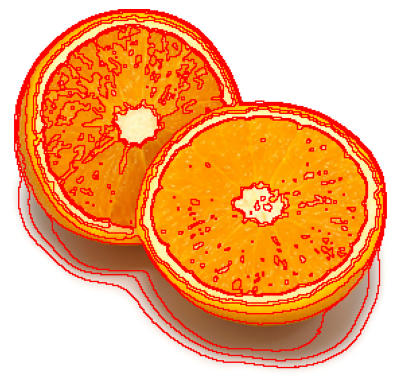

In [22]:
def kmeans_example():
    K = 8              # number of clusters used
    L = 35             # number of iterations
    seed = 14           # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0   # image preblurring scale
    
    img = Image.open('Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
    
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm, centers = kmeans_segm(I, K, L, seed)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/result/orange_K8_kmeans.png')

kmeans_example()

**Question 3**<br>
What is the minimum value for K that you can use and still get no superpixel that covers parts from both halves of the orange? Illustrate with a figure.

**Answer**<br>
The minimum value of K that can be used is 8.

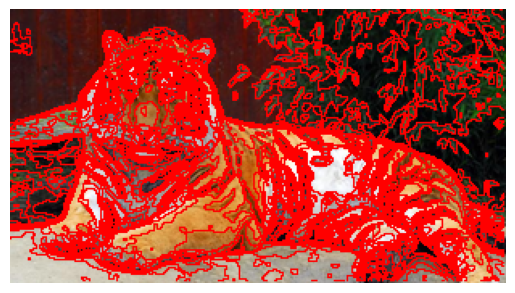

In [23]:
def kmeans_example():
    K = 15              # number of clusters used
    L = 35              # number of iterations
    seed = 14           # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0   # image preblurring scale
    
    img = Image.open('Images-jpg/tiger1.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
    
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm, centers = kmeans_segm(I, K, L, seed)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/result/tiger1_kmeans.png')

kmeans_example()

**Question 4** <br>
What needs to be changed in the parameters to get suitable superpixels for the tiger images as well? 

**Answer** <br>
The value of K is 15 and L is 35.

## Mean-shift Segmentation

In [24]:
def mean_shift_segm(I, spatial_bandwidth, colour_bandwidth, num_iterations):

    print('Find colour channels with K-means...')
    K = 20 # number of channels
    [ segm, centers ] = kmeans_segm(I, K, 33, 4321)
    ( height, width, depth ) = np.shape(I)
    idx = np.reshape(segm, (height, width))
    mapsw = np.zeros((height, width, K))
    mapsx = np.zeros((height, width, K))
    mapsy = np.zeros((height, width, K))
    [X, Y] = np.meshgrid(range(width), range(height))
    for k in range(K):
        mapsw[:,:,k] = (idx == k).astype(float)
        mapsx[:,:,k] = gaussian_filter(mapsw[:,:,k]*X, spatial_bandwidth, mode='nearest')
        mapsy[:,:,k] = gaussian_filter(mapsw[:,:,k]*Y, spatial_bandwidth, mode='nearest')
        mapsw[:,:,k] = gaussian_filter(mapsw[:,:,k],   spatial_bandwidth, mode='nearest')
    mapsw = np.reshape(mapsw, (-1, K)) + 1e-6
    mapsx = np.reshape(mapsx, (-1, K))
    mapsy = np.reshape(mapsy, (-1, K))

    print('Search for high density points...')
    constC = -0.5/(colour_bandwidth**2)
    x = np.reshape(X, (width*height, ))
    y = np.reshape(Y, (width*height, ))
    Ic = np.reshape(I, (width*height, 3))
    wei = np.exp(constC*(distance_matrix(Ic, centers)**2))
    for l in range(num_iterations):
        p = (np.round(y)*width + np.round(x)).astype(int)
        ww = mapsw[p,:] * wei
        w = np.sum(ww, axis=1)
        u = (np.matmul(ww, centers).T / w).T
        x = ((np.sum(mapsx[p,:] * wei, axis=1)).T / w).T
        y = ((np.sum(mapsy[p,:] * wei, axis=1)).T / w).T
        wei = (ww.T / w).T
        x = np.maximum(np.minimum(x, width-1), 0);
        y = np.maximum(np.minimum(y, height-1), 0);

    print('Assign high density points to pixels...')
    XY = np.stack((x, y))
    thr = 4.0
    val = 0
    mask = np.zeros((height*width, 1), dtype=np.short)
    for y in range(height):
        for x in range(width):
            p = y*width + x
            if mask[p] == 0:
                stack = [ p ]
                val = val + 1
                mask[p] = val
                while len(stack) > 0:
                    p0 = stack[-1]
                    xy = XY[:, p0]
                    y0 = int(p0/width)
                    x0 = p0 - y0*width
                    stack = stack[:-1]
                    pn = p0 + 1
                    if x0<width-1 and mask[pn]==0 and (np.sum((xy - XY[:, pn])**2)<thr):
                        stack = stack + [ pn ]
                        mask[pn] = val
                    pn = p0 - 1
                    if x0>0 and mask[pn]==0 and (np.sum((xy - XY[:, pn])**2)<thr):
                        stack = stack + [ pn ]
                        mask[pn] = val
                    pn = p0 + width
                    if y0<height-1 and mask[pn]==0 and (np.sum((xy - XY[:, pn])**2)<thr):
                        stack = stack + [ pn ]
                        mask[pn] = val
                    pn = p0 - width
                    if y0>0 and mask[pn]==0 and (np.sum((xy - XY[:, pn])**2)<thr):
                        stack = stack + [ pn ]
                        mask[pn] = val
    segm = np.reshape(mask, (height, width))
    return segm

Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...


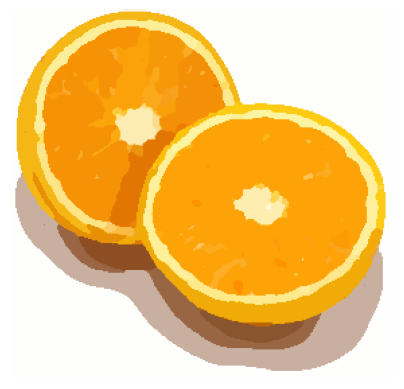

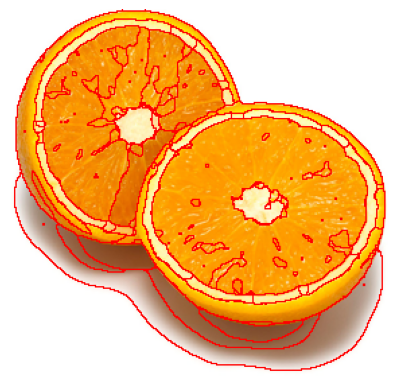

In [25]:
def mean_shift_example():
    scale_factor = 0.5         # image downscale factor
    image_sigma = 1.0          # image preblurring scale
    spatial_bandwidth = 2.0    # spatial bandwidth
    colour_bandwidth = 40.0    # colour bandwidth
    num_iterations = 40        # number of mean-shift iterations
    
    img = Image.open('Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
     
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm = mean_shift_segm(I, spatial_bandwidth, colour_bandwidth, num_iterations)
    Inew = mean_segments(img, segm)

    I = mean_segments(img, segm)

    plt.figure()
    image = Image.fromarray(I.astype(np.ubyte))
    plt.imshow(image)
    plt.axis('off')

    if True:
        Inew = overlay_bounds(img, segm)
    
    plt.figure()
    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('result/orange_meanshift.png')

mean_shift_example()

Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...


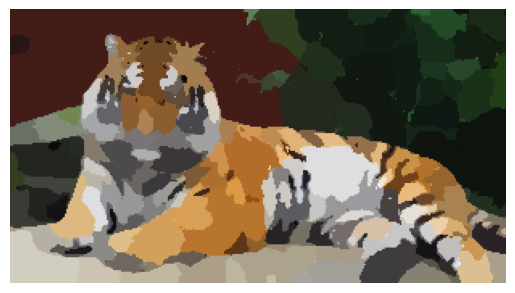

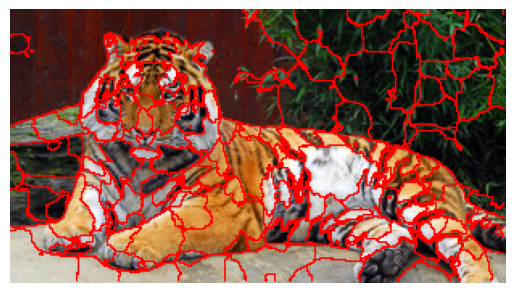

In [26]:
def mean_shift_example():
    scale_factor = 0.5         # image downscale factor
    image_sigma = 1.0          # image preblurring scale
    spatial_bandwidth = 5.0    # spatial bandwidth
    colour_bandwidth = 40.0     # colour bandwidth
    num_iterations = 40        # number of mean-shift iterations
    
    img = Image.open('Images-jpg/tiger1.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
     
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm = mean_shift_segm(I, spatial_bandwidth, colour_bandwidth, num_iterations)
    Inew = mean_segments(img, segm)

    I = mean_segments(img, segm)

    plt.figure()
    image = Image.fromarray(I.astype(np.ubyte))
    plt.imshow(image)
    plt.axis('off')

    if True:
        Inew = overlay_bounds(img, segm)
    
    plt.figure()
    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('result/tiger1_meanshift.png')

mean_shift_example()

Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...


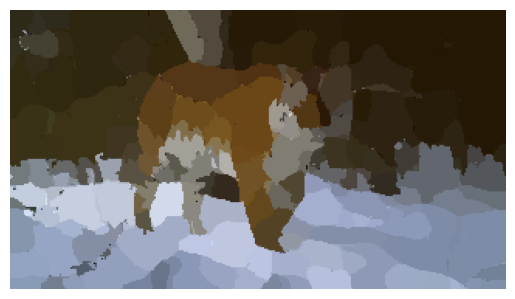

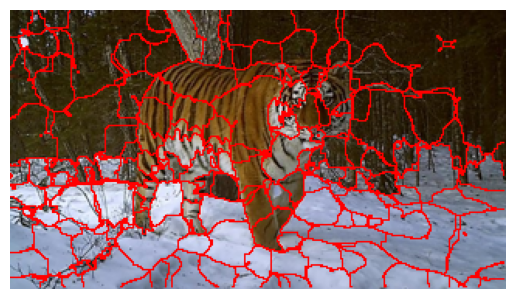

In [27]:
def mean_shift_example():
    scale_factor = 0.5         # image downscale factor
    image_sigma = 1.0          # image preblurring scale
    spatial_bandwidth = 5.0    # spatial bandwidth
    colour_bandwidth = 50.0     # colour bandwidth
    num_iterations = 40        # number of mean-shift iterations
    
    img = Image.open('Images-jpg/tiger2.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
     
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm = mean_shift_segm(I, spatial_bandwidth, colour_bandwidth, num_iterations)
    Inew = mean_segments(img, segm)

    I = mean_segments(img, segm)

    plt.figure()
    image = Image.fromarray(I.astype(np.ubyte))
    plt.imshow(image)
    plt.axis('off')

    if True:
        Inew = overlay_bounds(img, segm)
    
    plt.figure()
    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('result/tiger2_meanshift.png')

mean_shift_example()

Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...


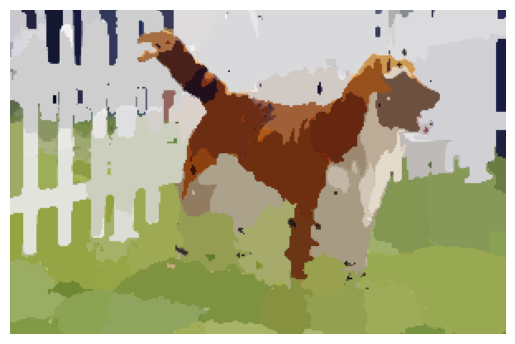

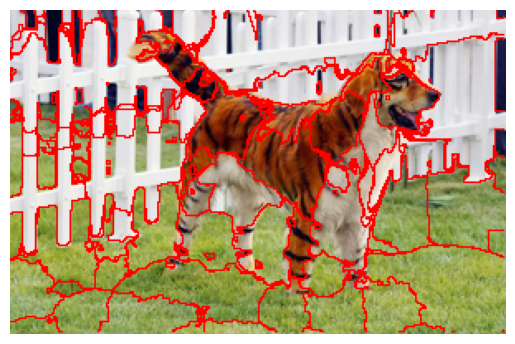

In [28]:
def mean_shift_example():
    scale_factor = 0.5         # image downscale factor
    image_sigma = 1.0          # image preblurring scale
    spatial_bandwidth = 10.0    # spatial bandwidth
    colour_bandwidth = 40.0     # colour bandwidth
    num_iterations = 40        # number of mean-shift iterations
    
    img = Image.open('Images-jpg/tiger3.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
     
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm = mean_shift_segm(I, spatial_bandwidth, colour_bandwidth, num_iterations)
    Inew = mean_segments(img, segm)

    I = mean_segments(img, segm)

    plt.figure()
    image = Image.fromarray(I.astype(np.ubyte))
    plt.imshow(image)
    plt.axis('off')

    if True:
        Inew = overlay_bounds(img, segm)
    
    plt.figure()
    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('result/tiger3_meanshift.png')

mean_shift_example()

**Question 5** <br>
How do the results change depending on the bandwidths? What settings did you prefer for the different images? Illustrate with an example image with the parameter that you think are suitable for that image.

**Answer** <br>
The spatial bandwidth is used to control the influence of the spatial proximity on the segments. If this is set to be large, the segments would be larger as a wider area would be considered around each pixel. It often results in the merging of nearby regions which have similar colours. The colour bandwidth is used to control how the variation in colours influences the segmentation. If this is set to be large, there can be more variation in colour present within the segment. When images have more fine colour regions present, a smaller colour bandwidth should be set to preserve details while applying segmentation. When the colour bandwidth is set to be too high, the image segments seem to be more smoothened as the variety of pixel values accepted within segments is larger.

**Question 6** <br>
What kind of similarities and differences do you see between K-means and mean-shift segmentation? 

**Answer** <br>
When using K-means segmentation, the algorithm is more sensitive to the initial placement of the centroids, and this can result in convergence to a local minima. When using mean-shift segmentation, the algorithm seeks the mode and therefore is less sensitive. Mean-shift segmentation has a higher computational complexity compared to K-means segmentation, especially for large datasets. K-means performs better in scenarios with well-separated, globular clusters, while mean-shift adapts to more complex cluster shapes and sizes. Both the algorithms make use of the RGB pixel values to determine segments/clusters. The K-means segmentation algorithm does not consider any spatial information unlike the mean-shift segmentation algorithm. The K-means algorithm also makes use of a pre-defined number of clusters when the mean-shift segmentation uses pre-defined bandwidths instead.

## Normalized Cut

In [29]:
def ncuts(A, D, n_ev):
    # Computes the n_ev smallest (non-zero) eigenvectors and eigenvalues of the 
    # of the Laplacian of A, where D is diagonal matrix with the row sums of A
    L = (D - A) + 1e-3*sparse.identity(np.size(D, 0))
    success = True
    try:
        #EVal, EV = sparse.linalg.lobpcg(L, X, M=D, largest=False)
        EVal, EV = sparse.linalg.eigsh(L, k=n_ev, M=D, which='SM', tol=1e-3, maxiter=10000)
    except:
        print("Failed to find eigenvectors")
        EVal = np.array([ 0, 0 ])
        EV = np.zeros((np.size(L, axis=0), 2))
        success = False
    return EV, EVal, success


# NcutValue - 2.1 Computing the Optimal Partition Ncut. eq (5)
#
# Synopsis
#  ncut = ncuts_value(T, U2, D, W);
#
# Inputs ([]s are optional)
#  (scalar) t        splitting point (threshold)
#  (vector) U2       N x 1 vector representing the 2nd smallest
#                     eigenvector computed at step 2.
#  (matrix) W        N x N weight matrix
#  (matrix) D        N x N diagonal matrix
#
# Outputs ([]s are optional)
#  (scalar) ncut     The value calculated at the right term of eq (5).
#                    This is used to find minimum Ncut.
#
# Authors
#  Naotoshi Seo <sonots(at)sonots.com>
#
# License
#  The program is free to use for non-commercial academic purposes,
#  but for course works, you must understand what is going inside to use.
#  The program can be used, modified, or re-distributed for any purposes
#  if you or one of your group understand codes (the one must come to
#  court if court cases occur.) Please contact the authors if you are
#  interested in using the program without meeting the above conditions.
#
# Changes
#  10/01/2006  First Edition
#  15/10/2021  Python version (Marten Bjorkman)

def ncuts_value(t, U2, W, D):
    x = np.where(U2 > t, 1, -1)
    d = D.diagonal()
    k = np.sum(d[x > 0]) / sum(d)
    b = k/(1 - k)
    y = (1 + x) - b*(1 - x)
    ncut = y.dot((D - W) @ y) / y.dot(D @ y)
    return ncut


# NcutPartition - Partitioning
#
# Synopsis
#  [sub ids ncuts] = ncuts_partition(I, W, sNcut, sArea, [id])
#
# Description
#  Partitioning. This function is called recursively.
#
# Inputs ([]s are optional)
#  (vector) I        N x 1 vector representing a segment to be partitioned.
#                    Each element has a node index of V (global segment).
#  (matrux) W        N x N matrix representing the computed similarity
#                    (weight) matrix.
#                    W(i,j) is similarity between node i and j.
#  (scalar) sNcut    The smallest Ncut value (threshold) to keep partitioning.
#  (scalar) sArea    The smallest size of area (threshold) to be accepted
#                    as a segment.
#  (string) [id]     A label of the segment (for debugg)
#
# Outputs ([]s are optional)
#  (cell)   Seg      A cell array of segments partitioned.
#                    Each cell is the each segment.
#  (cell)   Id       A cell array of strings representing labels of each segment.
#                    IDs are generated as children based on a parent id.
#  (cell)   Ncut     A cell array of scalars representing Ncut values
#                    of each segment.
#
# Requirements
#  NcutValue
#
# Authors
#  Naotoshi Seo <sonots(at)sonots.com>
#
# License
#  The program is free to use for non-commercial academic purposes,
#  but for course works, you must understand what is going inside to use.
#  The program can be used, modified, or re-distributed for any purposes
#  if you or one of your group understand codes (the one must come to
#  court if court cases occur.) Please contact the authors if you are
#  interested in using the program without meeting the above conditions.
#
# Changes
#  10/01/2006  First Edition
#  15/10/2021  Python version (Marten Bjorkman)

def ncuts_partition(I, W, sNcut, sArea, id, maxDepth, depth):
    N = np.shape(W)[0]
    d = np.sum(W, axis=1)
    D = sparse.spdiags(d.reshape(-1), [0], N, N, format='csr') # D = diagonal matrix

    # Step 2 and 3. Solve generalized eigensystem (D -W)*S = S*D*U (12).
    # (13) is not necessary thanks to smart matlab. Get the 2 smallests ('sm')
    [EV, EVal, success] = ncuts(W, D, 2)

    # 2nd smallest (1st smallest has all same value elements, and useless)
    U2 = EV[:, 1]
    
    # Step 3. Refer 3.1 Example 3.
    # Bipartition the graph at point that Ncut is minimized.
    t = np.mean(U2)
    if success == True:
        t = optimize.minimize(ncuts_value, t, args=(U2, W, D), method='Nelder-Mead', options={'maxiter': 20}).x
    A = np.where(U2 > t)[0]
    B = np.where(U2 <= t)[0]
    
    # Step 4. Decide if the current partition should be divided
    #   if either of partition is too small, stop recursion.
    #   if Ncut is larger than threshold, stop recursion.
    if success == True:
        ncut = ncuts_value(t, U2, W, D)
    else:
        ncut = sNcut
    print(f'Cutting ncut=%.3f sizes=(%d,%d) %s' % (ncut, np.size(A), np.size(B), id))
    if np.size(A)<sArea or np.size(B)<sArea or ncut>=sNcut or depth>maxDepth:
        Seg = [ I ]
        Id = [ id ]     # for debugging
        Ncut = [ ncut ] # for debugging
        return Seg, Id, Ncut

    # recursively create segments of A
    SegA, IdA, NcutA = ncuts_partition(I[A], W[:,A][A,:], sNcut, sArea, id+'-A', maxDepth, depth+1)

    # recursively create segments of B
    SegB, IdB, NcutB = ncuts_partition(I[B], W[:,B][B,:], sNcut, sArea, id+'-B', maxDepth, depth+1)
    
    # concatenate cell arrays
    Seg  =  SegA + SegB 
    Id   =  IdA + IdB
    Ncut =  NcutA + NcutB
    return Seg, Id, Ncut


def ncuts_affinity(im, XY_RADIUS, RGB_SIGMA):
    (h, w, _) = np.shape(im)

    # Find all pairs of pixels within a distance of XY_RADIUS
    rad = int(math.ceil(XY_RADIUS))
    [di,dj] = np.meshgrid(range(-rad, rad + 1), range(-rad, rad + 1))
    dv = (dj**2 + di**2) <= XY_RADIUS**2
    di = di[dv]
    dj = dj[dv]
    [i,j] = np.meshgrid(range(w), range(h))
    i = np.repeat(i[:, :, np.newaxis], len(di), axis=2)
    j = np.repeat(j[:, :, np.newaxis], len(di), axis=2)
    i_ = i - di
    j_ = j - dj
    v = np.where((i_ >= 0) & (i_ < w) & (j_ >= 0) & (j_ < h))
    pair_i =  j[v]*w +  i[v]
    pair_j = j_[v]*w + i_[v]

    # Weight each pair by the difference in RGB values, divided by RGB_SIGMA
    RGB = np.reshape(im/RGB_SIGMA, (-1, 3))
    R = RGB[pair_i,:]
    W = np.exp(-np.sum((RGB[pair_i,:] - RGB[pair_j,:])**2, axis=1)).astype(np.float64)
    
    # Construct an affinity matrix
    A = sparse.csr_matrix((W, (pair_i, pair_j)), shape=(w*h, w*h))

    return A


def norm_cuts_segm(I, colour_bandwidth, radius, ncuts_thresh, min_area, max_depth):
    
    (nRow, nCol, c) = np.shape(I)
    N = nRow * nCol
    V = np.reshape(I, (N, c))    
    
    print('Compute affinity matrix...')
    W = ncuts_affinity(I, radius, colour_bandwidth)

    print('Solve eigenvalue problems to find partitions...')
    Seg = np.arange(N, dtype=np.int32)
    [Seg, Id, Ncut] = ncuts_partition(Seg, W, ncuts_thresh, min_area, 'ROOT', max_depth, 1)

    segm = np.zeros((N, 1), dtype=np.int32)
    for i in range(len(Seg)):
        segm[Seg[i]] = i
        print('Ncut = %f  %s' % (Ncut[i], Id[i]))
        
    segm = np.reshape(segm, (nRow, nCol)).astype(np.int32)
    return segm

In [30]:
def norm_cuts_example():
    colour_bandwidth = 20.0  # color bandwidth
    radius = 1               # maximum neighbourhood distance
    ncuts_thresh = 0.10      # cutting threshold
    min_area = 200           # minimum area of segment
    max_depth = 12           # maximum splitting depth
    scale_factor = 0.25      # image downscale factor
    image_sigma = 0.5        # image preblurring scale

    img = Image.open('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
     
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm = norm_cuts_segm(I, colour_bandwidth, radius, ncuts_thresh, min_area, max_depth)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 3/Karen/result/orange_normcuts1.png')

**Question 7** <br>
Does the ideal parameter setting vary depending on the images? If you look at the images, can you see a reason why the ideal settings might differ? Illustrate with an example image using the parameters you prefer for that image.

**Answer** <br>
The parameters defined have the following impacts: <br>
**colour_bandwidth:** This is used to define a threshold for colour similarity. If the value is set to be larger, a wider range of colours would be considered similar. This leads to more homogeneous segments.<br>
**radius:** Radius is the maximum distance within which two pixels are considered neighbors. If this is larger, a larger area is considered for segment inclusion. This means that pixels which are further away will also impact the number of segments made. <br>
**ncuts_thresh:** This is used to define minimum cost considered before cutting into segments. A segment is not further divided if the normalized cost is below the threshold. If it is larger, then more similar areas will be separable.<br>
**min_area:** This sets the minimum area for a segment. Segments smaller than this threshold will not be considered.
max_depth: This defines the maximum depth of the segmentation tree. It controls how many times a segment can be recursively divided. Increasing this will result in more segments being made.<br>
**scale_factor:** This scales down the image before processing. A smaller scale factor can be used to reduce the image size to decrease processing time.<br>
**image_sigma:** This is defined for the gaussian blurring parameter to reduce the noise and smaller details that could possibly alter the image segments.<br>
As the complexity of the image in terms of varying colours and textures increases, the number of segments need to be higher to represent the image. For this reason, max_depth should not be lower for complex images like the tiger. ncuts_threshold should also be increased. The colour_bandwidth should also be set low to allow for more colours to be differentiated.<br>

**Question 8** <br>
Which parameter(s) was most effective for reducing the subdivision and still result in a satisfactory segmentation?

**Answer**<br>
To reduce the subdivision while maintaining segmentation, we can use these parameters: ncuts_thresh, min_area and max_depth.

**Question 9** <br>
Why does Normalized Cut prefer cuts of approximately equal size? Does this happen in practice?

**Answer** <br>
This is based on the cost evaluation of the cuts. The cost is normalised based on the total connections of all the nodes in the graph and this ensures the sizes of each segment are scaled according to each other. If any cut separates a very small set of nodes from the rest of the graph, the normalization factor will be high, increasing the cut cost.

**Question 10**<br>
Did you manage to increase radius and how did it affect the results? 

**Answer**<br>
Radius is the maximum distance within which two pixels are considered neighbors. If this is larger, a larger area is considered for segment inclusion. This means that pixels which are further away will also impact the number of segments made. Increasing the radius with result in larger segments which has more colour variations within each segment.

## Segmentation using Graph Cuts